# Making Inputs for Chemception
This notebook shows a function that creates the inputs needed for the Chemception machine learning model. 

It is modeled after code from [Abdulk084/Chemception](https://github.com/Abdulk084/Chemception/blob/master/chemcemption.ipynb)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np

## Define the Function
We are going to make a function that goes from SMILES string to image following the best-performing, EngA representation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


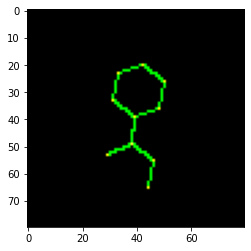

In [2]:
def generate_image(smiles: str, size: int = 80, resolution: float = 0.5) -> np.ndarray:
    """Generate an image of a molecule with atomic information in the channels
    
    Channel 0: Atomic number of atoms
    Channel 1: Bond order
    Channel 2: Partial charges
    Channel 3: Hybridizaton of the atom
    
    Args:
        smiles: SMILES string of a molecule
        size: Size of the image
        resolution: Spatial resolution of the pixels
    Returns:
        A 4-channel image
    """
    
    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate the 2D coordinates of the molecule
    AllChem.Compute2DCoords(mol)
    coords = mol.GetConformer(0).GetPositions()[:, :2]  # Drop the z dimension
    
    # Center the molecule in the middle of a box
    width = size * resolution
    mean_position = coords.mean(axis=0)
    coords += width / 2 - mean_position 
    
    # Get the pixel location for each atom
    atom_pixel = np.round(coords / resolution).astype(int)
    atom_pixel = np.clip(atom_pixel, 0, size-1)
    
    # Initialize the output image
    output = np.zeros((size, size, 4), dtype=np.float32)
    
    # Add the atom information
    mol.ComputeGasteigerCharges()
    for atom, p in zip(mol.GetAtoms(), atom_pixel):
        output[p[0], p[1], 0] = atom.GetAtomicNum()
        output[p[0], p[1], 2] = atom.GetProp("_GasteigerCharge")
        output[p[0], p[1], 3] = atom.GetHybridization().real
        
    # Add in the bonds to channel 1
    bond_channel = output[:, :, 1]
    for bond in mol.GetBonds():
        # Get the coordinates of atoms on either side of bonds
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        b_pixel = atom_pixel[bidx]
        e_pixel = atom_pixel[eidx]
        
        # Compute a path of at least the image size number of pixels in between
        frac = np.linspace(0, 1, size)
        bond_pixels = e_pixel + frac[:, None] * (b_pixel - e_pixel)
        bond_pixels = np.round(bond_pixels).astype(int)
        
        # Set all of those values to the bond type value
        btype = bond.GetBondTypeAsDouble()
        for pix in bond_pixels:
            bond_channel[pix[0], pix[1]] = btype
    return output
    
output = generate_image('c1ccccc1C(O)ON', resolution=0.15)
plt.imshow(output[:,:,:3])